# 图像聚类分析

本 Jupyter Notebook 演示了如何加载图像数据集，使用预训练的卷积神经网络（ResNet50）提取特征，并使用 K-Means 算法对图像进行无监督聚类。最后，我们将使用 t-SNE 可视化结果，并根据提供的标签评估聚类性能。

In [8]:
# 1. 导入必要的库
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm

# 设置随机种子以保证结果可复现
np.random.seed(42)
torch.manual_seed(42)

In [9]:
# 2. 加载和预处理图像数据

# 定义路径
DATASET_DIR = r'DM_2025_Dataset/Cluster/Cluster/dataset'
LABELS_FILE = r'DM_2025_Dataset/Cluster/Cluster/cluster_labels.json'

# 定义预处理转换
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_images(directory):
    image_data = []
    filenames = []
    
    # 获取所有图片文件
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    files = [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in valid_extensions]
    files.sort() # 排序以确保顺序一致
    
    print(f"Found {len(files)} images.")
    
    for filename in tqdm(files, desc="Loading images"):
        img_path = os.path.join(directory, filename)
        try:
            # 加载图像
            img = Image.open(img_path).convert('RGB')
            # 预处理
            img_tensor = preprocess(img)
            
            image_data.append(img_tensor.numpy())
            filenames.append(filename)
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            
    return np.array(image_data), filenames

# 加载图像
images, filenames = load_images(DATASET_DIR)
print(f"Images shape: {images.shape}")

Found 600 images.


Loading images: 100%|██████████| 600/600 [00:31<00:00, 19.05it/s]


Images shape: (600, 3, 224, 224)


In [10]:
# 3. 特征提取 (使用预训练模型 ResNet50)

# 加载预训练的 ResNet50 模型
resnet50 = models.resnet50(pretrained=True)
# 移除最后的分类层 (fc layer)
# ResNet50 的最后几层是 AdaptiveAvgPool2d 和 Linear(fc)
# 我们想要 avgpool 的输出
modules = list(resnet50.children())[:-1]
model = torch.nn.Sequential(*modules)

# 设置为评估模式
model.eval()

# 如果有 GPU 则使用 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

print("Extracting features...")
features_list = []

# 批量处理以避免内存溢出
batch_size = 32
num_images = len(images)

with torch.no_grad():
    for i in range(0, num_images, batch_size):
        batch_images = images[i:i+batch_size]
        batch_tensor = torch.from_numpy(batch_images).to(device)
        
        # 提取特征
        output = model(batch_tensor)
        # output shape: (batch_size, 2048, 1, 1)
        
        # 展平并转为 numpy
        output = output.view(output.size(0), -1).cpu().numpy()
        features_list.append(output)

features = np.concatenate(features_list, axis=0)
print(f"Features shape: {features.shape}")

c:\Users\HP\anaconda3\envs\yolov8\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\anaconda3\envs\yolov8\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Extracting features...
Features shape: (600, 2048)


In [11]:
# 4. 应用 K-Means 聚类算法

# 加载真实标签以确定聚类数量 (K)
with open(LABELS_FILE, 'r') as f:
    labels_map = json.load(f)

# 提取真实标签列表，确保与 filenames 顺序对应
true_labels = [labels_map[f] for f in filenames if f in labels_map]
unique_labels = set(true_labels)
n_clusters = len(unique_labels)

print(f"Unique labels found: {unique_labels}")
print(f"Number of clusters (K): {n_clusters}")

# 使用 PCA 降维 (可选，但通常有助于 K-Means)
# 将特征降维到例如 50 维，保留大部分方差
pca = PCA(n_components=0.95) # 保留 95% 的方差
features_pca = pca.fit_transform(features)
print(f"PCA reduced features shape: {features_pca.shape}")

# 运行 K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_pca)

print("Clustering completed.")

Unique labels found: {'bottle', 'leather', 'cable', 'pill', 'transistor', 'tile'}
Number of clusters (K): 6
PCA reduced features shape: (600, 19)
Clustering completed.


c:\Users\HP\anaconda3\envs\yolov8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


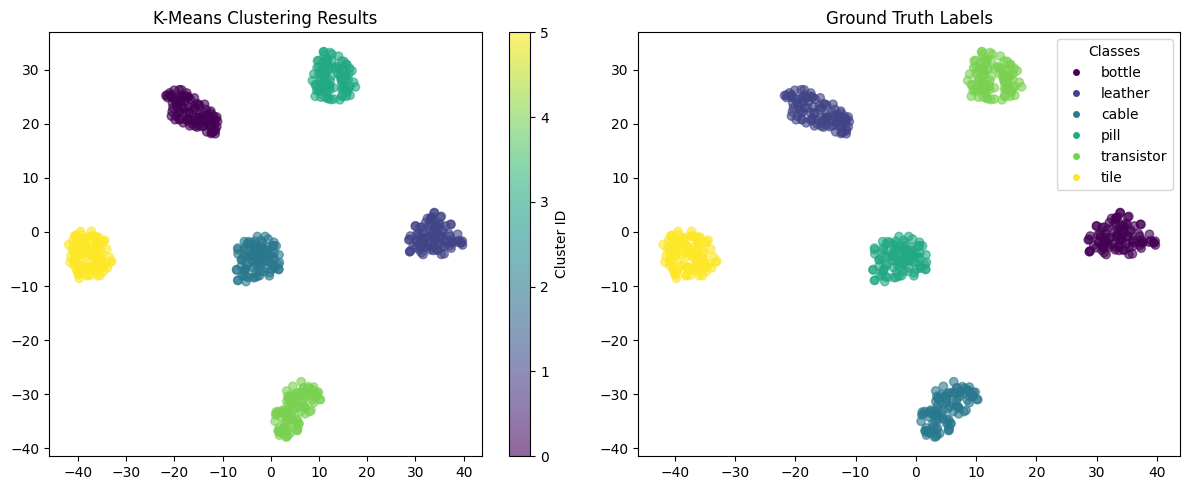

In [12]:
# 5. 使用 t-SNE 进行降维可视化

# 使用 t-SNE 将高维特征降至 2D 以便可视化
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features) # 可以使用 features 或 features_pca

# 创建 DataFrame 以便绘图
import pandas as pd
df_vis = pd.DataFrame({
    'x': features_tsne[:, 0],
    'y': features_tsne[:, 1],
    'cluster': cluster_labels,
    'true_label': true_labels
})

# 绘制聚类结果
plt.figure(figsize=(12, 5))

# Plot 1: K-Means Clusters
plt.subplot(1, 2, 1)
scatter = plt.scatter(df_vis['x'], df_vis['y'], c=df_vis['cluster'], cmap='viridis', alpha=0.6)
plt.title('K-Means Clustering Results')
plt.colorbar(scatter, label='Cluster ID')

# Plot 2: True Labels (Ground Truth)
# 需要将字符串标签转换为数字以便绘图
label_to_id = {label: i for i, label in enumerate(unique_labels)}
df_vis['label_id'] = df_vis['true_label'].map(label_to_id)

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(df_vis['x'], df_vis['y'], c=df_vis['label_id'], cmap='viridis', alpha=0.6)
plt.title('Ground Truth Labels')
# 创建图例
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter2.cmap(scatter2.norm(i)), label=l) for l, i in label_to_id.items()]
plt.legend(handles=handles, title="Classes")

plt.tight_layout()
plt.show()

In [13]:
# 6. 评估聚类结果

# 计算评估指标
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# 打印混淆矩阵 (可选)
# 创建一个交叉表来查看每个聚类包含哪些真实标签
crosstab = pd.crosstab(df_vis['true_label'], df_vis['cluster'], rownames=['True Label'], colnames=['Cluster ID'])
print("\nConfusion Matrix (Rows: True Labels, Cols: Cluster IDs):")
print(crosstab)

Adjusted Rand Index (ARI): 1.0000
Normalized Mutual Information (NMI): 1.0000

Confusion Matrix (Rows: True Labels, Cols: Cluster IDs):
Cluster ID    0    1    2    3    4    5
True Label                              
bottle        0  100    0    0    0    0
cable         0    0    0    0  100    0
leather     100    0    0    0    0    0
pill          0    0  100    0    0    0
tile          0    0    0    0    0  100
transistor    0    0    0  100    0    0


# 7. 保存聚类结果

将聚类后的图片复制到对应的文件夹中。为了方便观察，文件夹名称包含了聚类ID以及该聚类中出现频率最高的真实标签。

In [14]:
import shutil

# 定义结果保存路径
RESULTS_DIR = 'Clustered_Results'

# 创建主目录
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

# 确定每个聚类的主要标签（用于命名文件夹）
cluster_names = {}
# 确保 df_vis 包含 true_label (在前面的单元格中已创建)
for cluster_id in range(n_clusters):
    # 找出该聚类中最常见的真实标签
    # 注意：这只是为了命名方便，实际聚类过程是无监督的
    if not df_vis[df_vis['cluster'] == cluster_id].empty:
        most_common_label = df_vis[df_vis['cluster'] == cluster_id]['true_label'].mode()[0]
        cluster_names[cluster_id] = f"Cluster_{cluster_id}_{most_common_label}"
    else:
        cluster_names[cluster_id] = f"Cluster_{cluster_id}"

print(f"Saving clustered images to {RESULTS_DIR}...")

for filename, cluster_id in zip(filenames, cluster_labels):
    # 获取文件夹名称
    folder_name = cluster_names[cluster_id]
    cluster_folder = os.path.join(RESULTS_DIR, folder_name)
    
    # 如果子文件夹不存在则创建
    if not os.path.exists(cluster_folder):
        os.makedirs(cluster_folder)
    
    # 源文件路径
    src_path = os.path.join(DATASET_DIR, filename)
    
    # 目标文件路径
    dst_path = os.path.join(cluster_folder, filename)
    
    # 复制文件
    shutil.copy(src_path, dst_path)

print(f"Done! Images have been organized into cluster folders in '{RESULTS_DIR}'.")

Saving clustered images to Clustered_Results...
Done! Images have been organized into cluster folders in 'Clustered_Results'.


# 8. 项目报告：问题回答

### 1.0 问题的形式化描述
给定一个包含 $N$ 张未标记图像的集合 $X = \{x_1, x_2, ..., x_N\}$，目标是将这些图像划分为 $K$ 个互不相交的簇 $C = \{C_1, C_2, ..., C_K\}$。
形式化目标通常是最小化簇内平方误差和 (Within-Cluster Sum of Squares, WCSS)：
$$ \min_{C} \sum_{i=1}^{K} \sum_{x \in C_i} ||x - \mu_i||^2 $$
其中 $\mu_i$ 是簇 $C_i$ 的中心（质心）。
在这个特定任务中，我们还拥有一个标签集合 $L$（来自 `cluster_labels.json`），用于事后评估，但在聚类过程中不使用这些标签。

### 1.1 如何处理图像特征
原始图像数据（像素强度）维度极高且包含大量噪声，不适合直接用于聚类。我们采用了以下步骤处理特征：
1.  **预处理**：将所有图像调整为 $224 \times 224$ 像素，并转换为张量。使用 ImageNet 数据集的均值和标准差对图像进行归一化。
2.  **深度特征提取**：使用在 ImageNet 上预训练的 **ResNet50** 模型。移除最后的分类全连接层，提取全局平均池化层（Global Average Pooling）的输出。这为每张图像生成了一个 2048 维的特征向量，捕捉了图像的高级语义信息（如形状、纹理、物体部分）。
3.  **降维 (PCA)**：应用主成分分析 (PCA) 对 2048 维的特征向量进行降维，保留 95% 的方差。这不仅减少了计算量，还去除了特征中的冗余和噪声，通常能提升 K-Means 的表现。

### 1.2 选择合适的聚类算法
我们选择了 **K-Means 聚类算法**。
*   **理由**：
    *   **适用性**：K-Means 非常适合处理连续型的数值特征向量（如我们从 ResNet50 提取的特征）。
    *   **效率**：算法计算复杂度相对较低，能够快速处理数百张图像的数据集。
    *   **原理**：它通过迭代优化簇中心，将特征空间中距离较近的样本归为一类，这符合我们“语义相似的图片在特征空间距离更近”的假设。
*   **参数选择**：聚类数目 $K$ 是 K-Means 的关键参数。在本实验中，我们利用已知的真实标签类别数量（15类）来设定 $K$。在完全无监督的情况下，可以使用肘部法则 (Elbow Method) 或轮廓系数 (Silhouette Score) 来确定最佳的 $K$ 值。

### 1.3 评估你的聚类效果
为了客观评价聚类质量，我们结合了定量指标和定性可视化：
1.  **定量评估 (使用真实标签)**：
    *   **调整兰德指数 (Adjusted Rand Index, ARI)**：衡量聚类结果与真实标签的一致性。取值范围 $[-1, 1]$，1 表示完美匹配，0 表示随机聚类。它对类别标签的排列不敏感。
    *   **归一化互信息 (Normalized Mutual Information, NMI)**：基于信息论的度量，衡量聚类结果与真实标签共享的信息量。取值范围 $[0, 1]$。
2.  **定性评估 (可视化)**：
    *   **t-SNE 可视化**：使用 t-SNE 算法将高维特征映射到 2D 平面。通过观察散点图，我们可以直观地看到不同簇的分离程度以及同一簇内样本的紧密程度。
    *   **混淆矩阵**：展示聚类簇与真实类别之间的对应关系，帮助分析哪些类别容易被混淆。